In [1]:
# Libraries
import BondGraphTools as bgt
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import matplotlib.colors
from pylab import rcParams
import rdflib
from lxml import etree
import pandas
import re
import xml.etree.ElementTree as ET
import copy
import difflib
import os
import collections
from collections import Counter
from matplotlib import markers
from scipy.signal import find_peaks

FMA = pandas.read_csv('FMA.csv')
CHEBI = pandas.read_csv('CHEBI.csv')
OPB = pandas.read_csv('OPB.csv')
GO = pandas.read_csv('GO.csv')


fmaID = FMA['Class ID']
fmaLabel= FMA['Preferred Label']
chebiID = CHEBI['Class ID']
chebiLabel= CHEBI['Preferred Label']
opbID = OPB['Class ID']
opbLabel= OPB['Preferred Label']
goID = GO['Class ID']
goLabel= GO['Preferred Label']

c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (41,71,75,77,99,100,103,113,114,138,140,156,157,158,178,198) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (11,12,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Either just run this box or uncomment the next 2 boxes in which you'll be asked to enter the category and location
# of each file manually
categories=[['m'], ['m'], ['m'], ['m'], ['m']];
addresses=['/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L5.cellml',
 '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L2.cellml',
 '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L3.cellml',
 '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L1.cellml',
 '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L4.cellml']

In [3]:
# def catRecognition():
    
#     print('Please select the category of the models according to the following list:')
    
#     print('\n')
#     print('MAPK ==> insert "m"')

#     print('\n')
    
    
#     cat=[]
#     add=[]


#     e='Invalid Input'
#     while True:
#         try:
#             c=input('Enter the category of the model : ')
#             c=difflib.get_close_matches(c, ['m'])
#             cat.append(c)

#             add.append(input('Enter the location address for the corresponding file : '))

#             more=input('More reactions?(Y/N)')
#             if more.lower() != 'y':
#                 break

#         except Exception as e:
#             print(e)
            
# #     return[cat,add]

In [4]:
# # Here, the category of each reaction is asked along with the file location. Enter the location of the cellml file 
# # similar to the ones above (Markdown Cell)
# [categories,addresses]=catRecognition()

In [5]:
def getAnnotations(add):
    parser = etree.XMLParser(recover=True)
    root = etree.parse(add, parser).getroot()
    rdfGraph = rdflib.Graph()
    for rdfElement in root.iter():
        if rdfElement.tag.endswith('RDF'):
            try:
                rdfGraph.parse(data = etree.tostring(rdfElement))
            except:
                pass
            
    def getLeaves(sbj, graph):
        triples = list(graph.triples((sbj,None,None)))
        leaves = []
        if len(triples)>0:
            for s, p, o in triples:
                result =  getLeaves(o,graph)
                leaves += result
            return list(set(leaves))
        else:
            return [sbj]
        
    # Opens the CellML file and returns the list of variables names
    base=os.path.basename(add)
    f = open(base,'r')
    text = f.read()
    root = ET.fromstring(text)

    rdfs = root.findall('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}RDF')

    List1=[]
    for child in rdfs:
        for grand in child:
            List1.append(grand.attrib.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about'))
    
    List = list(dict.fromkeys(List1))
    List.remove('#metaid0')


    triplesList={}
    for i in range(len(List)):
        sbj = rdflib.URIRef(List[i])
        triplesList[i]=getLeaves(sbj, rdfGraph)

        # In this part we match the number found in the rdf of the CellML file 
        # with the ones found in the "Class IDs" and "Preferred Labels"

    annotations1={}

    for i in range(len(triplesList)):
        annotations1[i]=[]
        for k in range(len(triplesList[i])):
            l=triplesList[i][k]
            if 'opb' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for OPB
                for j in range(len(opbID)):
                    numID=re.findall(r'\d+', opbID[j])
                    if numCell == numID:
                        annotations1[i].append(opbLabel[j])
            elif 'chebi' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for CHEBI
                for j in range(len(chebiID)):
                    numID=re.findall(r'\d+', chebiID[j])
                    if numCell == numID:
                        annotations1[i].append(chebiLabel[j])
            elif 'fma' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for FMA
                for j in range(len(fmaID)):
                    numID=re.findall(r'\d+', fmaID[j])
                    if numCell == numID:
                        annotations1[i].append(fmaLabel[j])

            elif 'go' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for GO
                for j in range(len(goID)):
                    numID=re.findall(r'\d+', goID[j])
                    if numCell == numID:
                        annotations1[i].append(goLabel[j])

            elif 'thermodynamic constant' in l.lower(): # 'thermodynamic constant' is a free-style description!
                annotations1[i].append('thermodynamic constant')


    for i in range(len(annotations1)):
        annotations1[i]=[x.lower() for x in annotations1[i]] 

    annotations = {}; k=0;

    for key,value in annotations1.items():
        if value not in annotations.values():
            annotations[k] = value
            k+=1

    return [List,annotations,root]

In [6]:
def valExtraction(annotations,root,List): # Extracting values from the cellml file
    
    keytoAmounts=[]; varID=[]; variables=[]; els=[]; init=[];

    components = root.findall('{http://www.cellml.org/cellml/1.1#}component')


    for comp in components:
        variables.append(comp.findall('{http://www.cellml.org/cellml/1.1#}variable'))


    for var in variables:
        for v in var:   #Here search for the variable names(els) and their initial amounts(init)
            els.append(v.attrib['{http://www.cellml.org/metadata/1.0#}id'])   

            if 'initial_value' in v.attrib: # if any initial value exists take it
                init.append(v.attrib['initial_value'])    
            else:
                init.append(None)
    return[els,init]

In [7]:
# In the following script the two above functions (getAnnotations,valExtraction) are used to extract the annotations,
# variable names, and amounts. For instance, all the annotations of all the files will be saved in ONE
# dictionary (annotationsMAPKunsorted) as annotationsMAPKunsorted={'0':{...,...,...}, '1':{...,...,...}, ...}
listMAPK={}; annotationsMAPKunsorted={}; rootMAPK={};
elementsMAPK={}; initialsMAPK={}; 
for i in range(len(categories)):
    if categories[i][0] == 'm':
        [listMAPK[str(i)],annotationsMAPKunsorted[str(i)],rootMAPK[str(i)]]=getAnnotations(addresses[i])        
        [elementsMAPK[str(i)],initialsMAPK[str(i)]]=valExtraction(annotationsMAPKunsorted[str(i)],rootMAPK[str(i)],listMAPK[str(i)])
                
    else:
        pass

In [8]:
model=bgt.new(name='MAPK Cascades')

In [9]:
def mapkModelMaker(Model,annotations): # MAPK loops BG model
    
    # Dictionaries containing the reference annotations for each MAPK cycle
    mapkCascades={'mapk_Dict_1':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P
            5: ['concentration of chemical', 'map kinase kinase kinase activity'],  # MKKK
            6: ['concentration of chemical', 'activation of mapkkk activity'], # MKKKP
            7: ['concentration of chemical', 'map kinase kinase kinase kinase activity'],  # E1=MKKKK                                 
            8: ['map kinase phosphatase activity', 'concentration of chemical'], # E2=MKKK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'map kinase kinase kinase activity'],  # K_MKKK
            15: ['thermodynamic constant','concentration of chemical', 'activation of mapkkk activity'], # K_MKKKP
            16: ['map kinase kinase kinase kinase activity','thermodynamic constant','concentration of chemical'], # K_MKKKK      
            17: ['thermodynamic constant','map kinase phosphatase activity', 'concentration of chemical'], # K_MKKK_Pase
            18: ['thermodynamic constant','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant'], # K_C2
            20: ['reaction rate constant','map kinase kinase kinase activity','phosphorylation','atp binding'], # r1
            21: ['adp binding','activation of mapkkk activity', 'phosphorylation','reaction rate constant'], # r2
            22: ['adp binding', 'activation of mapkkk activity', 'dephosphorylation', 'reaction rate constant'], # r3
            23: ['dephosphorylation','activation of mapkkk activity', 'phosphate ion binding','reaction rate constant']}, # r4  


            'mapk_Dict_2':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P
            5: ['concentration of chemical', 'map kinase kinase activity'],  # MKK
            6: ['concentration of chemical', 'activation of mapkk activity'], # MKKP
            7: ['concentration of chemical', 'activation of mapkkk activity'], # E1=MKKKP
            8: ['concentration of chemical', 'phosphatase binding'], # E2=MKK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'map kinase kinase activity'],  # K_MKK
            15: ['thermodynamic constant','concentration of chemical', 'activation of mapkk activity'], # K_MKKP
            16: ['thermodynamic constant','concentration of chemical', 'activation of mapkkk activity'], # K_E1=K_MKKKP
            17: ['thermodynamic constant','concentration of chemical', 'phosphatase activity'], #K_E2
            18: ['thermodynamic constant','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['thermodynamic constant','concentration of chemical','protein dephosphorylation'], # K_C2
            20: ['reaction rate constant','map kinase kinase activity','phosphorylation','atp binding'], # r1
            21: ['adp binding','activation of mapkk activity', 'phosphorylation','reaction rate constant'], # r2
            22: ['adp binding', 'activation of mapkk activity', 'dephosphorylation', 'reaction rate constant'], # r3
            23: ['dephosphorylation','map kinase kinase activity', 'phosphate ion binding','reaction rate constant']}, # r4
                 
            'mapk_Dict_3':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P
            5: ['concentration of chemical', 'activation of mapkk activity'],  # MKKP
            6: ['concentration of chemical', 'mitogen-activated protein kinase kinase binding'], # MKKPP
            7: ['concentration of chemical', 'activation of mapkkk activity'],  # E1=MKKKP                    
            8: ['concentration of chemical', 'phosphatase binding'], # E2=MKK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'activation of mapkk activity'],  # K_MKKP
            15: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase kinase binding'], # K_MKKPP
            16: ['thermodynamic constant','concentration of chemical', 'activation of mapkkk activity'], # K_MKKKP (E1)
            17: ['thermodynamic constant','concentration of chemical', 'phosphatase binding'], # K_MKKPase (E2)
            18: ['thermodynamic constant','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant'], # K_C2
            20: ['phosphorylation','protein phosphorylation','reaction rate constant','atp binding','activation of mapkkk activity'], # r1                      
            21: ['phosphorylation','protein phosphorylation','reaction rate constant','adp binding','mitogen-activated protein kinase kinase binding'],# r2
            22: ['mitogen-activated protein kinase kinase binding','dephosphorylation','protein dephosphorylation','reaction rate constant'], #r3 
            23: ['phosphate ion binding','dephosphorylation','protein dephosphorylation','reaction rate constant','activation of mapkk activity']}, # r4
                 
            'mapk_Dict_4':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P                
            5:  ['concentration of chemical', 'map kinase activity'], # MK
            6: ['concentration of chemical', 'activation of mapk activity'], # MKP
            7: ['concentration of chemical', 'mitogen-activated protein kinase kinase binding'],# E1=MKKPP
            8: ['concentration of chemical', 'phosphatase complex'],  # E2=MK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'map kinase activity'], # K_MK
            15: ['thermodynamic constant','concentration of chemical', 'activation of mapk activity'],  # K_MKP
            16: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase kinase binding'], # K_MKKPP
            17: ['thermodynamic constant','concentration of chemical', 'phosphatase complex'], # K_MK_Pase
            18: ['thermodynamic constant','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant'], # K_C2
            20: ['phosphorylation','protein phosphorylation','reaction rate constant','atp binding', 'mitogen-activated protein kinase kinase binding'], # r1
            21: ['adp binding','phosphorylation','protein phosphorylation','reaction rate constant', 'activation of mapk activity'], # r2
            22: ['activation of mapk activity','dephosphorylation','protein dephosphorylation','reaction rate constant'], #r3 
            23: ['dephosphorylation','protein dephosphorylation','reaction rate constant','phosphate ion binding','map kinase activity']},# r4
                
            'mapk_Dict_5':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P 
            5: ['concentration of chemical', 'activation of mapk activity'], # MKP
            6: ['concentration of chemical', 'mitogen-activated protein kinase binding'], # MKPP
            7: ['concentration of chemical', 'mitogen-activated protein kinase kinase binding'], #E1=MKKPP   
            8: ['concentration of chemical',  'phosphatase complex'],  # E2=MK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'activation of mapk activity'], # MKP
            15: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase binding'], # MKPP               
            16: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase kinase binding'], #K_E1(MKKPP)   
            17: ['thermodynamic constant','concentration of chemical',  'phosphatase complex'],  # K_E2(MK_Pase)               
            18: ['thermodynamic constant','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant'], # K_C2
            20: ['phosphorylation','reaction rate constant','atp binding','mitogen-activated protein kinase kinase binding'], #r1               
            21: ['phosphorylation','reaction rate constant','adp binding','mitogen-activated protein kinase kinase binding'], #r2               
            22: ['reaction rate constant','dephosphorylation','protein dephosphorylation','mitogen-activated protein kinase binding'], #r3               
            23: ['reaction rate constant','dephosphorylation','phosphate ion binding','activation of mapk activity']}} #r4               
                           
              


    # Counting the number of unique entities in each loop to detect the loop
    # Based on a number of specific entities, the number of the loop in the MAPK cascade is determined
    
    E1={}; E2={}; C1={}; C2={}; M={}; MP={}; ATP={}; ADP={}; P={}; Re1={}; Re2={}; Re3={}; Re4={}; zeroJunctionE1={};
    zeroJunctionE2={}; zeroJunctionC1={}; zeroJunctionC2={}; zeroJunctionM={}; zeroJunctionMP={}; zeroJunctionATP={};
    zeroJunctionADP={}; zeroJunctionP={}; oneJunctionReactantsRe1={}; oneJunctionProductsRe2={}; oneJunctionReactantsRe3={}; 
    oneJunctionProductsRe4={}; 
    
    # Finding the loop which each input file corresponds to:
    Loop={}
    for a in range(len(annotations)):
        MKKKK_found=0; MKKK_found=0; MKKKP_found=0; MKPP_found=0; 
        MKK_found=0; MKKp_found=0; MKKPase_found=0; MKKPP_found=0; MK_found=0; MKP_found=0;
        for aa in range(len(annotations[str(a)])): 
            if 'map kinase kinase kinase kinase activity' in annotations[str(a)][aa]:# MKKKK
                MKKKK_found+=1
            elif 'map kinase kinase kinase activity' in annotations[str(a)][aa]: # MKKK
                MKKK_found+=1
            elif 'activation of mapkkk activity' in annotations[str(a)][aa]: # MKKKP
                MKKKP_found+=1
            elif 'map kinase kinase activity' in annotations[str(a)][aa]: # MKK
                MKK_found+=1
            elif 'activation of mapkk activity' in annotations[str(a)][aa]: # MKKP
                MKKp_found+=1    
            elif 'phosphatase binding' in annotations[str(a)][aa]: # MKK_Pase
                MKKPase_found+=1 
            elif 'mitogen-activated protein kinase kinase binding' in annotations[str(a)][aa]: # MKKPP
                MKKPP_found+=1
            elif 'map kinase activity' in annotations[str(a)][aa]: # MK
                MK_found+=1
            elif 'activation of mapk activity' in annotations[str(a)][aa]: # MKP
                MKP_found+=1
            elif 'mitogen-activated protein kinase binding' in annotations[str(a)][aa]: # MKPP
                MKPP_found+=1
                
        if MKKKK_found != 0 and MKKK_found != 0 : # It's the first loop in the cascade
            Loop[str(a)]=[]
            Loop[str(a)].append(list(mapkCascades.keys()).index('mapk_Dict_1')); # The index of the file that is the first loop
        elif MKK_found != 0 :
            Loop[str(a)]=[]
            Loop[str(a)].append(list(mapkCascades.keys()).index('mapk_Dict_2')); # The index of the file that is the second loop
        elif MKKp_found != 0 and MKKPase_found != 0 and MKKPP_found !=0:
            Loop[str(a)]=[]
            Loop[str(a)].append(list(mapkCascades.keys()).index('mapk_Dict_3')); # The index of the file that is the third loop
        elif MK_found != 0 :
            Loop[str(a)]=[]
            Loop[str(a)].append(list(mapkCascades.keys()).index('mapk_Dict_4')); # The index of the file that is the fourth loop
        elif MKPP_found != 0 and MKKPP_found != 0 and MKP_found !=0:
            Loop[str(a)]=[]
            Loop[str(a)].append(list(mapkCascades.keys()).index('mapk_Dict_5')); # The index of the file that is the fifth loop
           
                 
    newAnnot={}
    for key,value,loopk,loopv in zip(annotations.keys(),annotations.values(),Loop.keys(),Loop.values()):
        if key==loopk: 
            newAnnot[str(loopv[0])]=copy.deepcopy(value)
            


            
    for a in newAnnot.keys():        
        E1[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][7]), library="BioChem")  
        E2[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][8]), library="BioChem")  
        C1[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][9]), library="BioChem")
        C2[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][10]), library="BioChem")
        M[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][5]), library="BioChem")   
        MP[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][6]), library="BioChem")  
        ATP[int(a)] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[int(a)][2]), library="BioChem")
        ADP[int(a)] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[int(a)][3]), library="BioChem")
        P[int(a)] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[int(a)][4]), library="BioChem")

        # Reactions
        Re1[int(a)] = bgt.new("Re" , name=set(list(mapkCascades.values())[int(a)][20]) , library="BioChem")
        Re2[int(a)] = bgt.new("Re" , name=set(list(mapkCascades.values())[int(a)][21]) , library="BioChem")
        Re3[int(a)] = bgt.new("Re" , name=set(list(mapkCascades.values())[int(a)][22]) , library="BioChem")
        Re4[int(a)] = bgt.new("Re" , name=set(list(mapkCascades.values())[int(a)][23]) , library="BioChem")

        # Junctions
        zeroJunctionE1[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][7]))
        zeroJunctionE2[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][8]))
        zeroJunctionC1[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][9]))
        zeroJunctionC2[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][10]))
        zeroJunctionM[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][5]))
        zeroJunctionMP[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][6]))
        zeroJunctionATP[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][2]))
        zeroJunctionADP[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][3]))
        zeroJunctionP[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][4]))
        oneJunctionReactantsRe1[int(a)] = bgt.new("1", name=set(list(mapkCascades.values())[int(a)][20]))
        oneJunctionProductsRe2[int(a)] = bgt.new("1", name=set(list(mapkCascades.values())[int(a)][21]))
        oneJunctionReactantsRe3[int(a)] = bgt.new("1", name=set(list(mapkCascades.values())[int(a)][22]))
        oneJunctionProductsRe4[int(a)] = bgt.new("1", name=set(list(mapkCascades.values())[int(a)][23]))



    
    # Dictionary containing the generated BG components ("Components")
    Components={}; mergeableComponents={}
    for a in newAnnot.keys(): 

        Components[a]={0:E1[int(a)], 1:E2[int(a)], 2:C1[int(a)], 3:C2[int(a)], 4:M[int(a)], 5:MP[int(a)], 
                  6:ATP[int(a)], 7:ADP[int(a)], 8:P[int(a)], 9:Re1[int(a)], 10:Re2[int(a)], 11:Re3[int(a)],
                  12:Re4[int(a)],13:zeroJunctionE1[int(a)],14:zeroJunctionE2[int(a)],15:zeroJunctionC1[int(a)],
                  16:zeroJunctionC2[int(a)],17:zeroJunctionM[int(a)],18:zeroJunctionMP[int(a)],19:zeroJunctionATP[int(a)],
                  20:zeroJunctionADP[int(a)], 21:zeroJunctionP[int(a)],22:oneJunctionReactantsRe1[int(a)],
                  23:oneJunctionProductsRe2[int(a)], 24:oneJunctionReactantsRe3[int(a)], 25:oneJunctionProductsRe4[int(a)]} 
        
         # List of mergeable components along with their corresponding junctions for later merging ("mergeableComponents")
        #For now, C1 & C2 are not considered among mergeable components despite having the same annotations!
        #Maybe later will be added ....
        mergeableComponents[a]={E1[int(a)], E2[int(a)], M[int(a)], MP[int(a)], ATP[int(a)], ADP[int(a)], P[int(a)],
                                zeroJunctionE1[int(a)],zeroJunctionE2[int(a)], zeroJunctionM[int(a)],zeroJunctionMP[int(a)], 
                                zeroJunctionATP[int(a)], zeroJunctionADP[int(a)],zeroJunctionP[int(a)]}  
    
       
        
    # Connectivity Matrix for one cycle
    connectivityMatrix=np.zeros((26,26))
    connectivityMatrix[9][15]=1; connectivityMatrix[10][23]=1; connectivityMatrix[11][16]=1; connectivityMatrix[12][25]=1; 
    connectivityMatrix[13][22]=1; connectivityMatrix[13][0]=1; connectivityMatrix[14][1]=1; connectivityMatrix[14][24]=1; 
    connectivityMatrix[15][2]=1; connectivityMatrix[15][10]=1; connectivityMatrix[16][3]=1; connectivityMatrix[16][12]=1; 
    connectivityMatrix[17][4]=1; connectivityMatrix[17][22]=1; connectivityMatrix[18][5]=1; connectivityMatrix[18][24]=1;
    connectivityMatrix[19][6]=1; connectivityMatrix[19][22]=1; connectivityMatrix[20][7]=1; connectivityMatrix[21][8]=1; 
    connectivityMatrix[22][9]=1; connectivityMatrix[23][13]=1; connectivityMatrix[23][18]=1; connectivityMatrix[23][20]=1;
    connectivityMatrix[24][11]=1; connectivityMatrix[25][14]=1; connectivityMatrix[25][17]=1; connectivityMatrix[25][21]=1; 
    
    
    cm=[]
    for i in range(len(connectivityMatrix)):
        cm.append(list(connectivityMatrix[i])) # Connectivity Matrix for one module(cycle/loop) of MAPK cascade      

    
            
    return [mapkCascades,cm,mergeableComponents,Components,newAnnot]

In [10]:
[mapkCascades,cm,mergeableComponents,Components,annotationsMAPK]=mapkModelMaker(model,annotationsMAPKunsorted)

In [11]:
def checkMutual(category,annotations,List,els,init): # Checking for similar annotations 
    
    if len(category)>1: # if more than one reaction is added, there's a probability of mutual annotations
        commonAnnots={}; #common annotations in the form of pairs of modules (k1,k2)
        CommonAmountsA={};  # First element of the pair (firstModule,secondModule) stored in this dictionary
        CommonAmountsB={};  # Second element of the pair (firstModule,secondModule) stored in this dictionary
        
        modelsNumber = len(annotations)  # The number of the input files (models)
        k=-1; kk=0
        for i,a in zip(range(modelsNumber),annotations.keys()):
            kk+=1; ii=0;
            
            while ii+kk < modelsNumber:  # Finding common anotations between each pair of the modules
                commonAnnots[a,list(annotations.keys())[ii+kk]]=[]
                k+=1
                CommonAmountsA[str(k)]=[]; CommonAmountsB[str(k)]=[]
                for a1 in range(len(list(annotations.values())[i])):
                    for a2 in range(len(list(annotations.values())[ii+kk])):
# mergeables ...        
                        if set(list(annotations.values())[i][a1]) == set(list(annotations.values())[ii+kk][a2]) and list(annotations.values())[i][a1] !=[]:
                            commonAnnots[list(annotations.keys())[i],list(annotations.keys())[ii+kk]].append(list(annotations.values())[i][a1]) 
                            varIDA=List[str(i)][a1].strip('#')
                            for e in range(len(els[str(i)])):
                                if varIDA == els[str(i)][e].strip('#'):
                                    
                                    CommonAmountsA[str(k)].append(init[str(i)][e])

                            varIDB=List[str(ii+kk)][a2].strip('#')
                            for e in range(len(els[str(ii+kk)])):
                                if varIDB == els[str(ii+kk)][e]:
                                    CommonAmountsB[str(k)].append(init[str(ii+kk)][e])  
                ii+=1
                        
            
                     
            
    # Finding the variables with the same annotations and different values & ignoring the ones with same values    
    commonAnnotsDiffVals={}; CommonAmountsAA={}; CommonAmountsBB={};
    for k in range(len(list(commonAnnots.keys()))):
        commonAnnotsDiffVals[list(commonAnnots.keys())[k]]=[]
        CommonAmountsAA[list(commonAnnots.keys())[k]]=[]
        CommonAmountsBB[list(commonAnnots.keys())[k]]=[]
        for v in range(len(list(commonAnnots.values())[k])):
            if list(CommonAmountsA.values())[k][v] != list(CommonAmountsB.values())[k][v]:
                commonAnnotsDiffVals[list(commonAnnots.keys())[k]].append(list(commonAnnots.values())[k][v])
                CommonAmountsAA[list(commonAnnots.keys())[k]].append(list(CommonAmountsA.values())[k][v])
                CommonAmountsBB[list(commonAnnots.keys())[k]].append(list(CommonAmountsB.values())[k][v])
                
                

                    
    
    # Getting the preferred value from the user for the recognised same variables with different values
    for i in range(len(list(commonAnnotsDiffVals.keys()))):
        for j in range(len(list(commonAnnotsDiffVals.values())[i])):
            print('Different values found for: ')
            print('\n')
            print(list(commonAnnotsDiffVals.values())[i][j] ,list(commonAnnotsDiffVals.keys())[i], ':' , list(CommonAmountsAA.values())[i][j],  'and' , list(CommonAmountsBB.values())[i][j])   
            list(CommonAmountsAA.values())[i][j]=copy.deepcopy(input('Enter the preferred value:'))
               
        
        
    # copying the changed values to the list of initial amounts of the model    
    for i in range(len(list(commonAnnotsDiffVals.keys()))): # number of pairs of models 
        for j in range(len(list(commonAnnotsDiffVals.values())[i])):   
            for n,k in zip(range(len(annotations)),annotations.keys()): 
                for f in range(len(list(annotations[k].values()))):
                    if set(list(commonAnnotsDiffVals.values())[i][j]) == set(list(annotations[k].values())[f]):
                        varID=List[str(n)][f].strip('#')
                        for r in range(len(els[str(n)])):
                            if varID == els[str(n)][r].strip('#'): # Assigning the new values to the old ones in all the models
                                init[str(n)][r]=copy.deepcopy( list(CommonAmountsAA.values())[i][j]) 

                        
                  
    return[commonAnnots, init,commonAnnotsDiffVals,CommonAmountsAA,CommonAmountsBB]

In [12]:
[commonAnnots,initialsMAPK,commonAnnotsDiffVals,a,b]=checkMutual(categories,annotationsMAPK,listMAPK,elementsMAPK,initialsMAPK)        

In [13]:
# Detecting common components between the models along with their corresponding model number in modelNum_commonCompRemove
# We need to delete (n-1) of each (n) common found component
# By defining the modelNum_commonCompRemove, we exactly know which component is deleted from which model
modelNum_commonCompRemove=[]; # List of common components between the models along with their corresponding model number
for k in commonAnnots.keys():   # check if the common annotations found, are among the mergeable components?
    for v in commonAnnots[k]: 
        for kk in mergeableComponents.keys():
            for i in range(0,2):                
                if k[i] == kk:
                    for vv in mergeableComponents[kk]:
                        if set(v) == set(vv.name) and vv.metamodel == 'C': # if YES, find the corresponding species (C)
                            modelNum_commonCompRemove.append(int(kk)) # model number for recognizing that each component belongs to which model
                            modelNum_commonCompRemove.append(vv) 
                    break 
# if we have found (n) common components in (n) models, we need to remove (n-1) of them   
check=[]; length=len(modelNum_commonCompRemove); i=1; jointComps=[];
while i<length:
    
    if modelNum_commonCompRemove[i].name not in check:
        check.append(set(modelNum_commonCompRemove[i].name) )
        jointComps.append(modelNum_commonCompRemove[i-1])
        jointComps.append(modelNum_commonCompRemove[i])
        modelNum_commonCompRemove.pop(i)
        modelNum_commonCompRemove.pop(i-1)
    else:
        modelNum_commonCompRemove.pop(i)
        modelNum_commonCompRemove.pop(i-1)
                
    length = len(modelNum_commonCompRemove)        
    i+=2

# Now removing the extra model-components from modelNum_commonCompRemove
length=len(modelNum_commonCompRemove); i=0; j=0;
while i<length-3:
    j=copy.deepcopy(i+2)
    while j<length-1:
        
        if modelNum_commonCompRemove[i] == modelNum_commonCompRemove[j] and set(modelNum_commonCompRemove[i+1].name) == set(modelNum_commonCompRemove[j+1].name):
            modelNum_commonCompRemove.pop(j+1)
            modelNum_commonCompRemove.pop(j)
            length=len(modelNum_commonCompRemove)
        j+=2
        
        length=len(modelNum_commonCompRemove)
    length=len(modelNum_commonCompRemove)
    i+=2
        
            
    

    
        
# Creating a dictionary containing the initial connectivity matrices based on the number of the models.      
modelNum=len(Components); # number of the models
initialCMs={}
for i in Components.keys():
    initialCMs[i]=copy.deepcopy(cm)
    
    
# We have kept 'one' component from each duplicates bundle. Now all the remaining components in the 
# modelNum_commonCompRemove must be removed from the components
comps=[]; models=[];
for i in range(len(modelNum_commonCompRemove)):
    if type(modelNum_commonCompRemove[i]) == int:
        
        for j in range(len(Components[str(modelNum_commonCompRemove[i])])):
            if Components[str(modelNum_commonCompRemove[i])][j].metamodel=='C' and Components[str(modelNum_commonCompRemove[i])][j].name == modelNum_commonCompRemove[i+1].name :
                
                models.append(modelNum_commonCompRemove[i])
                comps.append(j)

modelsSorted={}; check=[];
for i in range(len(models)):
    if models[i] not in check:
        check.append(models[i])
        modelsSorted[models[i]]=[]
        modelsSorted[models[i]].append(comps[i])
    else:
        modelsSorted[models[i]].append(comps[i])
        
        
        
for k in modelsSorted.keys():
    modelsSorted[k]=sorted(set(modelsSorted[k]),reverse=True)
    
    

    
    
    
for m in modelsSorted.keys():
    for k in modelsSorted[m]:
        for j in range(len(initialCMs[str(m)])):
            del initialCMs[str(m)][j][k]  # Remove the corresponding column in the CM 
        del initialCMs[str(m)][k]  # Delete the corresponding row
        del Components[str(m)][k] # Deleting the duplicate components

# Adding the components to the model
for key in Components.keys():
    for k,v in Components[key].items():
        bgt.add(model,v)   

In [14]:
# Assigning the values based on the found annotations to the COMMON BG components such as Chemostats
def valueAllocation(annotations,mapkCascades,List,els,init,Model):    
    stateVarsInitials={}  # for getting the initial amounts of the state variables. 
    for i,key in zip(range(len(annotations)),annotations.keys()): 
        for v in range(len(list(annotations[key].values()))):
            for k in range(0,2): #finding amounts for T(Temperature) & R(Ideal gas constant)
                if set(list(annotations[key].values())[v]) == set(list(mapkCascades.values())[int(key)][k]):  
                    varID=List[str(i)][v].strip('#')                
                    for e in range(len(els[str(i)])):
                        if varID == els[str(i)][e]:
                            for param_index, (component, parameter_name) in Model.params.items():
                                if parameter_name is ("T"):
                                    bgt.set_param(Model, param_index, float(init[str(i)][e]))
                                elif parameter_name is ("R"):
                                    bgt.set_param(Model, param_index, float(init[str(i)][e]))


            for k in range(2,11):  # finding amounts for the state variables
                if set(list(annotations[key].values())[v]) == set(list(mapkCascades.values())[int(key)][k]):  
                    varID=List[str(i)][v].strip('#')                
                    for e in range(len(els[str(i)])):
                        if varID == els[str(i)][e]:
                            stateVarsInitials[str(list(mapkCascades.values())[int(key)][k])] = (float(init[str(i)][e]))

            for k in range(11,20):  # finding amounts for K (thermodynamic constants)
                if set(list(annotations[key].values())[v]) == set(list(mapkCascades.values())[int(key)][k]) and len(list(annotations[key].values())[v])==len(list(mapkCascades.values())[int(key)][k]): 
                    varID=List[str(i)][v].strip('#')               
                    for e in range(len(els[str(i)])):
                        if varID == els[str(i)][e]:
                            for param_index, (component, parameter_name) in Model.params.items():
                                if set(component.name) == set(list(mapkCascades.values())[int(key)][k-9]) and parameter_name is ("k"): # Belongs to the component at [k-9]
                                    bgt.set_param(Model, param_index, float(init[str(i)][e]))


            for k in range(20,24):  # finding amounts for the reaction rates (r)              
                if set(list(annotations[key].values())[v]) == set(list(mapkCascades.values())[int(key)][k]) and len(list(annotations[key].values())[v])==len(list(mapkCascades.values())[int(key)][k]):
                    varID=List[str(i)][v].strip('#')
                    for e in range(len(els[str(i)])):
                        if varID == els[str(i)][e]:
                            for param_index, (component, parameter_name) in Model.params.items():
                                if set(component.name) == set(list(mapkCascades.values())[int(key)][k]) and parameter_name is ("r"):
                                    bgt.set_param(Model, param_index, float(init[str(i)][e]))
       

    return[stateVarsInitials]

In [15]:
stateVarsInitials=valueAllocation(annotationsMAPK,mapkCascades,listMAPK,elementsMAPK,initialsMAPK,model)

In [16]:
# The list of components in the same order to match the rows/columns of the connectivity matrix
connectivityBondsRow=[];

for a in Components.keys(): 
    for i in Components[str(a)]:
        connectivityBondsRow.append(Components[str(a)][i])      

In [17]:
# In this function all the connectivity matrices of the modules are combined in one matrix
def CM_whole(CM):
    
    Length=0
    for n in CM.keys():
        Length+=len(CM[n])
    connectivity_matrix_0=np.zeros((Length,Length))  
    
    k=0
    for n in CM.keys():
        for i in range(k,k+len(CM[n])):
            for j in range(k,k+len(CM[n])):
                connectivity_matrix_0[i][j]=copy.deepcopy(CM[n][i-k][j-k])
        k+=len(CM[n])
    return connectivity_matrix_0

In [18]:
connectivity_matrix_0=CM_whole(initialCMs)

In [19]:
# Inserting "1"s in the whole Connectivity Matrix for model composition based on similar annotations
add={};  l1=0; l2=0; maxLimitSearch={}; check=0.1

# Limits for searching in the indices of the connectivityBondsRow (number of components in each model)
for m in initialCMs.keys():
    maxLimitSearch[m]=copy.deepcopy(len(initialCMs[m]))

m=0; check=[]       
for a in range(len(jointComps)):     
    if type(jointComps[a])==int:
        refModelJoint=copy.deepcopy(jointComps[a])
    else:
        refCompJoint=copy.deepcopy(jointComps[a])
        m=0; l1=0; l2=0;
        while m<len(maxLimitSearch):
            cycleNum=list(maxLimitSearch.keys())[m]    
            l2 += list(maxLimitSearch.values())[m]
            for i in range(l1,l2):
                if refModelJoint==int(cycleNum) and set(refCompJoint.name) == set(connectivityBondsRow[i].name) and connectivityBondsRow[i].metamodel == '0' and type(connectivityBondsRow[i]) is not tuple:
                    refindex=copy.deepcopy(i)
                    break
                elif refModelJoint!=int(cycleNum) and set(refCompJoint.name) == set(connectivityBondsRow[i].name) and connectivityBondsRow[i].metamodel == '0' and type(connectivityBondsRow[i]) is not tuple:
                    # Now add a "1" for the conection found between the modules (cycles/loops)
                    connectivity_matrix_0[refindex][i]=1
            l1 += list(maxLimitSearch.values())[m]
            m+=1

In [20]:
def BondsConnection(connectivity_matrix,CBR): 

    # Creating the bonds between the components based on the elements of the connectivity matrix
    Length=len(connectivity_matrix)
    bonds=[]  
    for i in range(Length):
        for j in range(Length):
            if connectivity_matrix[i][j]==1:
                bonds.append((CBR[i],CBR[j]))
 
    # connecting the components for a bond graph representation of the system
    for head, tail in bonds:
        bgt.connect(head,tail)

    return model

In [21]:
model=BondsConnection(connectivity_matrix_0,connectivityBondsRow)

In [22]:
# Matching the model's state variable names with the annotations and amounts saved in 'stateVarsInitials'
# Then, allocating those amounts to the state variables
x0=[]
for s in range(len(list(model.state_vars.values()))):

    for j in range(len(list(stateVarsInitials[0]))):
        q=eval(list(stateVarsInitials[0])[j])
        if set(list(model.state_vars.values())[s][0].name) == set(q):
            x0.append(list(stateVarsInitials[0].values())[j])
    


In [23]:
# Combining the initial values of the state variables
def combineDict(dicts):
    incKey = 0
    newDict = {}
    for val in dicts:
        newDict['x_'+str(incKey)] = val 
        incKey+=1
    return newDict

In [24]:
x_0=combineDict(x0)

In [224]:
t_span = [0,100]
t, x = bgt.simulate(model, timespan=t_span, control_vars={}, x0=x_0, dt=0.1)

In [316]:
import matplotlib.font_manager as font_manager

Text(0,0.5,'Concentration (mmol)')

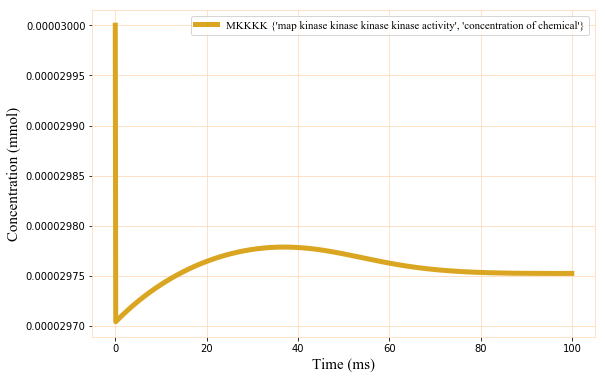

In [359]:
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='peachpuff')

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,x[:,17],'goldenrod', linewidth='5', label='MKKKK'+' '+str(list(model.state_vars.values())[17][0].name))
plt.legend(bbox_to_anchor=(1, 1), prop=font )

plt.grid(color='peachpuff')
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel('Concentration (mmol)', fontweight='bold',family='Times New Roman', fontsize=15)

Text(0,0.5,'Concentration (mmol)')

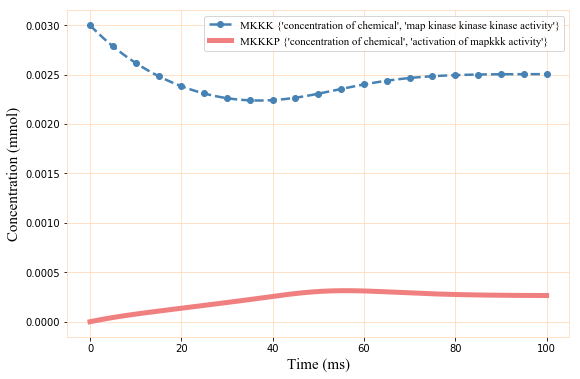

In [330]:
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='peachpuff')
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,x[:,21],'steelblue',marker= 'o',markevery=50,ms=6,linestyle='--',linewidth=2.5, label='MKKK'+' '+str(list(model.state_vars.values())[21][0].name))
plt.plot(t,x[:,9],'lightcoral', linewidth=5, label='MKKKP'+' '+str(list(model.state_vars.values())[9][0].name))
plt.legend(bbox_to_anchor=(1, 1), fontsize=8, prop=font)
plt.grid(color='peachpuff')
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel('Concentration (mmol)', fontweight='bold',family='Times New Roman', fontsize=15)

Text(0,0.5,'Concentration (mmol)')

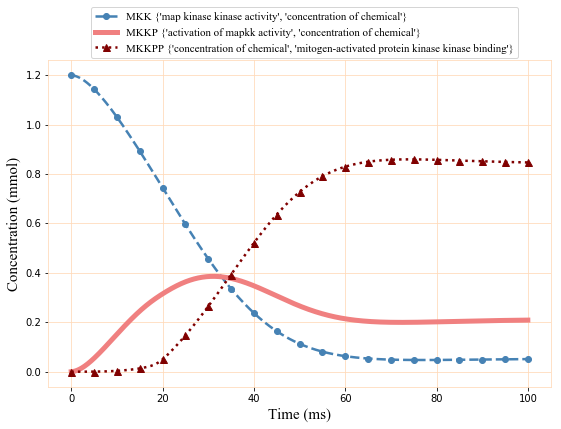

In [344]:
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='peachpuff')
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,x[:,13],'steelblue',marker= 'o',markevery=50,ms=6,linestyle='--',linewidth=2.5,label='MKK'+' '+str(list(model.state_vars.values())[13][0].name))
plt.plot(t,x[:,14],'lightcoral',linewidth=5 ,label='MKKP'+' '+str(list(model.state_vars.values())[14][0].name))
plt.plot(t,x[:,0],'maroon',marker= '^',markevery=50,ms=7,linestyle=':',linewidth=2.5, label='MKKPP'+' '+str(list(model.state_vars.values())[0][0].name))
plt.legend(loc='upper center',bbox_to_anchor=(0.51, 1.18), fontsize=8, prop=font)
plt.grid(color='peachpuff')
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel('Concentration (mmol)', fontweight='bold',family='Times New Roman', fontsize=15)

Text(0,0.5,'Concentration (mmol)')

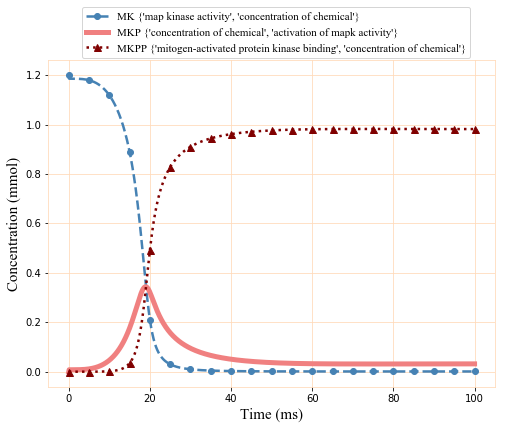

In [346]:
rcParams['figure.figsize'] = 8, 6
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='peachpuff')
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,x[:,24],'steelblue',marker= 'o',markevery=50,ms=6,linewidth=2.5, linestyle='--', label='MK'+' '+str(list(model.state_vars.values())[24][0].name))
plt.plot(t,x[:,4],'lightcoral', linewidth='5', label='MKP'+' '+str(list(model.state_vars.values())[4][0].name))
plt.plot(t,x[:,5],'maroon',marker= '^',markevery=50,ms=7,linestyle=':',linewidth=2.5, label='MKPP'+' '+str(list(model.state_vars.values())[5][0].name))
plt.legend(loc='upper center',bbox_to_anchor=(0.51, 1.18), fontsize=8, prop=font)
plt.grid(color='peachpuff')
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel('Concentration (mmol)', fontweight='bold',family='Times New Roman', fontsize=15)

Text(0,0.5,'% Activation')

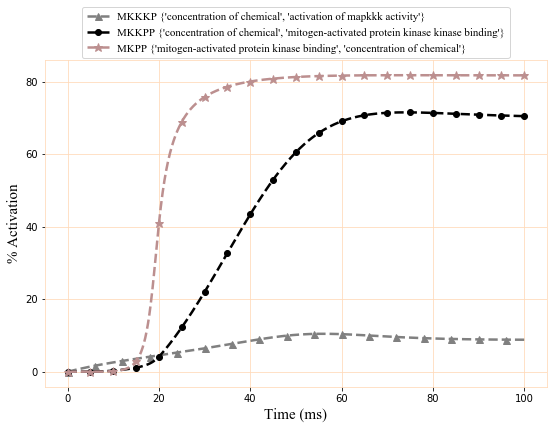

In [349]:
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='peachpuff')
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,100*x[:,9]/x[0,21],'grey',marker= '^',markevery=60,ms=7,linestyle='--',linewidth=2.5, label='MKKKP'+' '+str(list(model.state_vars.values())[9][0].name))
plt.plot(t,100*x[:,0]/x[0,13],'k',marker= 'o',markevery=50,ms=6,linestyle='--',linewidth=2.5,label='MKKPP'+' '+str(list(model.state_vars.values())[0][0].name))
plt.plot(t,100*x[:,5]/x[0,24],'rosybrown',marker= '*',markevery=50,ms=9, linestyle='--',linewidth=2.5, label='MKPP'+' '+str(list(model.state_vars.values())[5][0].name))

plt.legend(loc='upper center',bbox_to_anchor=(0.50, 1.18), fontsize=9, prop=font)
plt.grid(color='peachpuff')
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel("% Activation", fontweight='bold',family='Times New Roman', fontsize=15)

In [29]:
model.state_vars

{'x_0': (C: {'concentration of chemical', 'mitogen-activated protein kinase kinase binding'},
  'q_0'),
 'x_1': (C: {'concentration of chemical', 'phosphatase complex'}, 'q_0'),
 'x_2': (C: {'protein phosphorylation', 'concentration of chemical'}, 'q_0'),
 'x_3': (C: {'protein dephosphorylation', 'concentration of chemical'}, 'q_0'),
 'x_4': (C: {'concentration of chemical', 'activation of mapk activity'},
  'q_0'),
 'x_5': (C: {'mitogen-activated protein kinase binding', 'concentration of chemical'},
  'q_0'),
 'x_6': (C: {'concentration of chemical', 'atp binding'}, 'q_0'),
 'x_7': (C: {'concentration of chemical', 'adp binding'}, 'q_0'),
 'x_8': (C: {'concentration of chemical', 'phosphate ion binding'}, 'q_0'),
 'x_9': (C: {'concentration of chemical', 'activation of mapkkk activity'},
  'q_0'),
 'x_10': (C: {'phosphatase binding', 'concentration of chemical'}, 'q_0'),
 'x_11': (C: {'protein phosphorylation', 'concentration of chemical'}, 'q_0'),
 'x_12': (C: {'protein dephosphoryl